In [1]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright (c) 2020. Reda Bouadjenek, Deakin University                      +
#     Email:  reda.bouadjenek@deakin.edu.au                                    +
#                                                                              +
#  Licensed under the Apache License, Version 2.0 (the "License");             +
#   you may not use this file except in compliance with the License.           +
#    You may obtain a copy of the License at:                                  +
#                                                                              +
#                 http://www.apache.org/licenses/LICENSE-2.0                   +
#                                                                              +
#    Unless required by applicable law or agreed to in writing, software       +
#    distributed under the License is distributed on an "AS IS" BASIS,         +
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  +
#    See the License for the specific language governing permissions and       +
#    limitations under the License.                                            +
#                                                                              +
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
from gurobipy import *
import matplotlib.pyplot as plt


# Optimizing <i>expected</i> F1-Score using Linear Programming

## Installation

The algorithm described in this Notebook requires [Gurobi](https://www.gurobi.com/) to be installed in your Python environement. Please follow [these instructions](https://www.gurobi.com/documentation/9.1/quickstart_mac/software_installation_guid.html).
Once Gurobi is installed, you need to add it to your own Python environment. Doing so requires you to install the gurobipy module. The steps for doing this depend on your
platform. On Linux, you will need to open a terminal window, change your current directory to
the Gurobi <installdir> (the directory that contains the file setup.py), and issue the following
command:
```
python setup.py install
```


## 1- Motivation
We will argue that (expected) F1-Score of a substring is the only standard criteria that balances all of substring desiderata and is hence objective we should optimize.

To proceed with the formal derivation, we adopt the Boolean relevance framework in information retrieval and thus assume that a token $j$ has a ground truth relevance assessment $B(j)$ available at <i>evaluation time</i>.


Because selecting a substring implies a Boolean selection model (a substring either contains or do not contain tokens) and we have a probabilistic estimate of relevance $P(j)$ for each token, we propose to evaluate
<i>expected</i> variants of standard precision, recall, and F1-score of these substrings.


However, as standard for both precision and recall, we note that precision and recall alone can be trivially optimized by undesired solutions.  That is, the substring that selects all tokens would trivially maximize (expected) recall.  Similarly, the substring that selects the highest probability singleton token would maximize expected precision.  <i>This leaves expected F1-score as the only of these three objectives commonly used in Boolean information retrieval that does not have an undesired solution</i>.


## 2- Deriving Expected F1-Score (EF1)


To formally define expected F1-Score, we first begin with definitions of expected precision and recall.  Given a substring $S_{sub}$  of a string $S$ ($|S|=m$), the precision of $S_{sub}$ is defined as follows:
\begin{equation}
   P(S_{sub}) = \dfrac{\sum_{j \in S_{sub}} B(j)}{|S_{sub}|} = \dfrac{\sum_{j=1}^m B(j)I(j)}{\sum_{j=1}^m I(j)} 
\end{equation}

where the two variables  $I(j) \in \{0,1\}$ and $B(j) \in \{0,1\}$ are associated with each token $j$ of $S$: 

- $I(j)$ is an indicator referring to whether a token $j$ is part of $S_{sub}$ ($\textrm{true}\!=\!1$); 
- $B(j)$ is a Boolean random variable indicating the (ground truth) relevance of a tokan $j$ ($\textrm{relevant}\!=\!1$).


Given that $B(j)$ is a Boolean random variable, we can take the expectation of $P(S_{sub})$ leading to the following definition of <i>expected precision</i> $EP(S_{sub})$: 

\begin{equation}
EP(S_{sub})=\mathbb{E_{P}}\left[\dfrac{{ \sum_{j=1}^{m}}B(j)I(j)}{{ \sum_{j=1}^{m}}I(j)}\right]=\dfrac{{ \sum_{j=1}^{m}}\mathbb{E_{S}}[B(j)]I(j)}{{ \sum_{j=1}^{m}}I(j)}=\dfrac{{ \sum_{j=1}^{m}}P(j)I(j)}{{ \sum_{j=1}^{m}}I(j)}
\end{equation}

where the variable $P(j) \in [0,1]$ is the <i>probability</i> relevance of a token $j$.


Similarly the recall of a substring $R(S_{sub})$ is defined as:

\begin{equation}
   R(S_{sub}) = \dfrac{\sum_{j \in S_{sub}} B(j)}{\sum_{j \in S} B(j)} = \dfrac{\sum_{j=1}^m B(j)I(j)}{ \sum_{j=1}^m B(j)} 
\end{equation}


Taking a 1st order Taylor expansion, we have the following expectation approximation 
$\mathbb{E}(X/Y)\approx \mathbb{E}(X)/ \mathbb{E}(Y)$ for two dependent random variables $X$ and $Y$. Hence, we can now define an <i>approximated expected recall</i> as follows: 

\begin{equation}
   ER(S_{sub})=\mathbb{E_{P}}\left[\dfrac{{ \sum_{j=1}^{m}}B(j)I(j)}{\sum_{j=1}^m B(j)}\right]\approx\dfrac{{ \sum_{j=1}^{m}}\mathbb{E_{P}}[B(j)]I(j)}{{ \sum_{j=1}^{m}}\mathbb{E_{P}}[B(j)]}=\dfrac{{ \sum_{j=1}^{m}}P(j)I(j)}{{ \sum_{j=1}^{m}}P(j)}
\end{equation}


Finally, we define the <i>approximated expected F1-Scor</i> (EF1) using the <i>expected precision</i> and the <i>approximated expected recall</i> as follows: 
\begin{align}
    EF1(E)  \approx \dfrac{2\times EP\times ER}{EP+ER} = \dfrac{2\times\sum_{j=1}^m P(j)I(j)}{\sum_{j=1}^m I(j) + \sum_{j=1}^m P(j)}
    \label{eq:EF1}
\end{align}


## 3- Fractional MILP Formulation


We begin by reformulating the <b><i>Expected</i> F1-score (EF1)</b> objective to prepare for further optimization steps by replacing the global sum of scores of all tokens with a constant $C = \sum_{j=1}^m P(j)$:
\begin{equation}
\begin{aligned}
    EF1 &= \dfrac{2\times \sum_{j=1}^m P(j)I(j)}{\sum_{j=1}^m I(j) + \sum_{j=1}^m P(j)} = \dfrac{2 \times \sum_{j=1}^m P(j)I(j)}{\sum_{j=1}^m I(j) + C}
\end{aligned}
\end{equation}





In order to obtain the substring with the obtimal <b><i>Expected</i> F1-score</b>, we define the following fractional MILP:

\begin{equation}
\begin{aligned}
& \underset{I(j)}{\text{maximize}}
& & \dfrac{\sum_{j=1}^m P(j)I(j)}{\sum_{j=1}^m I(j) + C} \\
& s.t
& & \text{# Interval selection contraints.} \\
& & & 1 <=  s <= e <= m \\
& & & I(j) =
   \begin{cases}
     1, & \text{if $(s \leqslant j \leqslant e)$}  \\
     0, & \text{otherwise}
  \end{cases}
\end{aligned} 
\end{equation}

## 4- Transformation to a MILP

While there are no direct solvers for fractional MILPs, we can transform the former equation into a pure MILP form for which we have efficient and optimal solvers.  To do this, we use the Charnes-Cooper method and Glover linearization method with big-M constraints, where auxiliary variables $w(j)$ and $u$ are  introduced*. Here, $w(j)$ is defined as $w(j)=I(j)\times u$ with $u$ defined as follows:
\begin{equation}
u = \dfrac{1}{\sum_{j=1}^m I(j) + C}
\end{equation}

Then, the EF1 optimization problem is able to be transformed into the following MILP problem:
\begin{equation}
\begin{aligned}
& \underset{w,u,I,s,e}{\text{maximize}}
& & \sum_{j=1}^m P(j)w(j) \\
& s.t
& & \sum_{j=1}^m w(j) + uC = 1 \\
& & & w(j) \leqslant u, \quad w(j) \leqslant M\times I(j)  \\
& & & w(j) \geqslant u - M\times [1-I(j)] \\
& & & u > 0,  \quad I(j) \in \{0, 1\}, \quad w(j) \geqslant 0 \\
& & & \text{# Interval selection contraints.} \\
& & & 1 <=  s <= e <= m \\
& & & I(j) =
   \begin{cases}
     1, & \text{if $(s \leqslant j \leqslant e)$}  \\
     0, & \text{otherwise}
  \end{cases} \label{eq:cons1} 
\end{aligned}
\end{equation}

*https://optimization.mccormick.northwestern.edu/index.php/Mixed-integer_linear_fractional_programming_(MILFP)

## 5- Algorithm implementation

In [2]:
def select_LP_optimal_subsequence(probabilities):
    """
    This function optimizes the expected f1-score to choose the optimal subsequence 
    of probabilities.
    :param probabilities: the sequence of probabilities.
    :return: the start index and the end index of the optimal subsequence.
    """
    C = sum(probabilities)
    M = 1e4  # Value for Big M.
    dict_probabilities = dict({j: probabilities[j] for j in range(len(probabilities))})
    ###################
    # Define the model.
    ###################
    model = Model('EF1-Score')
    model.setParam( 'OutputFlag', False) # make Gurobi silent.
    # element variable
    w = model.addVars(dict_probabilities.keys(), lb=0.0, ub=1.0, vtype='C', name='w')
    I = model.addVars(dict_probabilities.keys(), lb=0.0, ub=1.0, vtype='B', name='I')
    u = model.addVar(lb=0, vtype='C', name='u')

    # Index variables
    Is = model.addVars(dict_probabilities.keys(), vtype='B', name='Is')
    Ie = model.addVars(dict_probabilities.keys(), vtype='B', name='Ie')

    s = model.addVar(lb=0, ub=len(dict_probabilities) - 1, vtype='I', name='s')
    e = model.addVar(lb=0, ub=len(dict_probabilities) - 1, vtype='I', name='e')

    # Objective function
    model.setObjective(w.prod(dict_probabilities), GRB.MAXIMIZE)

    # Constraints

    model.addConstr(quicksum(w[j] for j in range(len(dict_probabilities))) + u * C == 1.0, 'sum(w)+uC=1')
    model.addConstr(s <= e, 's<=e')
    for j in dict_probabilities:
        model.addConstr(w[j] <= u, f"w[{j}]<=u")
        model.addConstr(w[j] <= M * I[j], f"w[{j}]<=M*I({j})")
        model.addConstr(w[j] >= u - M * (1 - I[j]), f"w[{j}]>=u-M*[1-I({j})]")
        model.addConstr(w[j] >= 0.0, f"w[{j}]>=0.0")

        # Interval selection constraints
        model.addGenConstrAnd(I[j], [Is[j], Ie[j]], f"selection_constraint-{j}")

        model.addGenConstrIndicator(Is[j], True, s <= j)
        model.addGenConstrIndicator(Ie[j], True, e >= j)

        model.addGenConstrIndicator(Is[j], False, s >= j + 1)
        model.addGenConstrIndicator(Ie[j], False, e <= j - 1)

    model.optimize()
    # model.write("out.lp")
    optimal_value = 2 * model.getObjective().getValue() # optimal ef1 score
    return int(round(s.X)), int(round(e.X)), optimal_value


## 6- Example

In [3]:
text = ['A', 'Research', 'Fellow', 'position', 'is', 'available', 'in', 'Machine', 'Learning',
        'at', 'the', 'School', 'of', 'Computer', 'Science', 'of',
        'the', 'University', 'of', 'Birmingham', 'UK', '.',
        'The', 'appointment', 'is', 'in', 'connection', 'with', 'the', 'EPSRC', 'Fellowship', '.'
        ]

# question: in which university is the research position available?


probabilities = [0.5, 0.001, 0.001, 0.8, 0.005, 0.01, 0.005, 0.01, 0.005,
                 0.001, 0.91, 0.5, 0.01, 0.099, 0.099, 0.05,
                 0.0001, 0.5, 0.9, 0.99, 0.8, 0.7,
                 0.03, 0.1, 0.01, 0.001, 0.1, 0.01, 0.001, 0.1, 0.99, 0.0099]


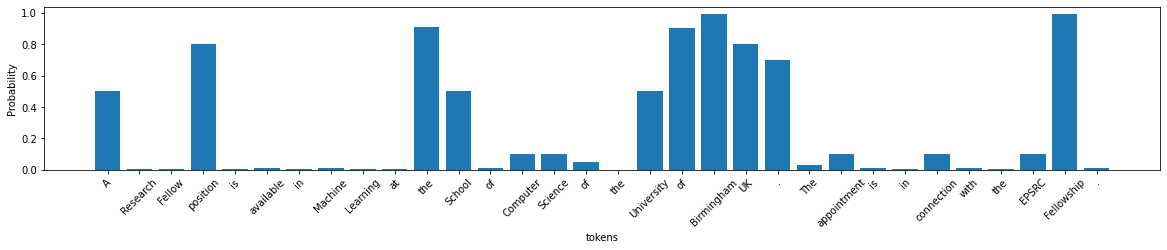

In [4]:
x = list(j for j in range(len(probabilities)))
plt.figure(figsize=(20, 3))
plt.bar(x, probabilities)  # A bar chart
plt.xlabel('tokens')
plt.ylabel('Probability')
plt.xticks(x, text, rotation='45')
plt.show()


In [5]:
s,e,_ = select_LP_optimal_subsequence(probabilities)

Academic license - for non-commercial use only - expires 2021-12-16
Using license file /home/reda/gurobi.lic


In [6]:
for i in range(s,e+1):
    print(text[i], end =" ")

University of Birmingham UK . 

## 7- Brute force search

In [7]:
def get_EF1_score():
    pass

In [8]:
def select_brute_force_optimal_subsequence(probabilities):
    pass